## Homework 4

Use this notebook as a starter

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [2]:
df = pd.read_csv('CreditScoring.txt')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [3]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [4]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [5]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [6]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [7]:
df.dtypes

seniority     int64
home         object
time          int64
age           int64
marital      object
records      object
job          object
expenses      int64
income        int64
assets        int64
debt          int64
amount        int64
price         int64
default       int32
dtype: object

In [8]:
num = list(df.dtypes[df.dtypes != 'object'].index)
num.remove('default')
cat = list(df.dtypes[df.dtypes == 'object'].index)

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [9]:
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df,test_size = 0.2, random_state=1)

In [10]:
len(df_full_train), len(df_test), len(df_test)/len(df_full_train)

(3563, 891, 0.25007016559079426)

In [78]:
len(df)

4454

In [11]:
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state=1)

In [12]:
y_train = df_train.default.values
y_val = df_val.default.values
y_test = df_test.default.values


del df_train['default']
del df_val['default']
del df_test['default']

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the default variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [13]:
num

['seniority',
 'time',
 'age',
 'expenses',
 'income',
 'assets',
 'debt',
 'amount',
 'price']

In [14]:
from sklearn.metrics import roc_auc_score
for kat in num:
        AUC = roc_auc_score(y_train,df_train[kat])
        if AUC < 0.5:
            AUC = roc_auc_score(y_train,-df_train[kat])
        print(kat,':',AUC)

seniority : 0.7093778624491943
time : 0.5608662489595051
age : 0.5732933272499939
expenses : 0.5009184217217011
income : 0.682006666132633
assets : 0.6486042567122802
debt : 0.5047829675783548
amount : 0.5910773431595518
price : 0.5043329862114843


Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [15]:
X_series = ['seniority', 'income', 'assets', 'records', 'job', 'home']
df_train = df_train[X_series]
df_val = df_val[X_series]

In [16]:

from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')

X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

In [17]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_val)[:, 1]

In [18]:
AUC = roc_auc_score(y_val,y_pred)

In [19]:
round(AUC,3)

0.811

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [20]:
actual_positive = (y_val ==1)
actual_negative = (y_val == 0)


In [21]:
t = 0.5
predict_positive = (y_pred >=t)
predict_negative = (y_pred<t)


In [22]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [23]:
confusion_matrix = np.array([[tn, fp], [fn, tp]])

In [24]:
confusion_matrix

array([[581,  64],
       [134, 112]])

In [25]:
confusion_matrix/confusion_matrix.sum()

array([[0.65207632, 0.07182941],
       [0.15039282, 0.12570146]])

In [26]:
prec = tp/(tp+fp)

In [27]:
prec

0.6363636363636364

In [28]:
rec = tp / (tp+fn)

In [29]:
rec

0.45528455284552843

In [30]:
thresholds = np.linspace(0,1,21)
actual_positive = (y_val ==1)
actual_negative = (y_val == 0)
dane_do_wykr = []
for t in thresholds:
    predict_positive = (y_pred >=t)
    predict_negative = (y_pred<t)
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    prec = round(tp/(tp+fp),3)
    rec = round(tp / (tp+fn),3)
    print(round(t,2), prec, rec)
    dane_do_wykr.append((round(t,2), prec, rec))

0.0 0.276 1.0
0.05 0.305 0.972
0.1 0.346 0.955
0.15 0.395 0.923
0.2 0.437 0.878
0.25 0.48 0.825
0.3 0.521 0.76
0.35 0.562 0.699
0.4 0.578 0.602
0.45 0.61 0.508
0.5 0.636 0.455
0.55 0.669 0.394
0.6 0.672 0.317
0.65 0.702 0.24
0.7 0.741 0.175
0.75 0.7 0.114
0.8 0.786 0.089
0.85 0.786 0.045
0.9 0.75 0.024
0.95 nan 0.0
1.0 nan 0.0


<ipython-input-30-92e5fb255788>:12: RuntimeWarning: invalid value encountered in long_scalars
  prec = round(tp/(tp+fp),3)


In [31]:
df_score=pd.DataFrame(dane_do_wykr)

In [32]:
df_score.columns = ['t','prec','rec']

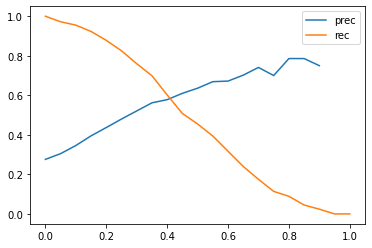

In [33]:
plt.plot(df_score.t,df_score.prec, label='prec')
plt.plot(df_score.t,df_score.rec, label='rec')
plt.legend()

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [34]:
thresholds = np.linspace(0,1,101)
actual_positive = (y_val ==1)
actual_negative = (y_val == 0)
dane_do_wykr_f1 = []
for t in thresholds:
    predict_positive = (y_pred >=t)
    predict_negative = (y_pred<t)
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    prec = round(tp/(tp+fp),3)
    rec = round(tp / (tp+fn),3)
    F1 = 2 * prec*rec/(prec+rec)
    print(round(t,2), F1)
    dane_do_wykr_f1.append((round(t,2), F1))

0.0 0.432601880877743
0.01 0.43627834245504304
0.02 0.44399374021909227
0.03 0.4491670588235294
0.04 0.4609867704280156
0.05 0.46430696945967115
0.06 0.47351906614785993
0.07 0.4826171693735499
0.08 0.491554524361949
0.09 0.5025633154259401
0.1 0.5079631053036125
0.11 0.5142938461538461
0.12 0.5229661016949153
0.13 0.536677370030581
0.14 0.5457342444950645
0.15 0.5532397572078908
0.16 0.5645439393939394
0.17 0.5668601986249046
0.18 0.5743683409436834
0.19 0.5825699168556312
0.2 0.5835528517110267
0.21 0.5852352490421456
0.22 0.5980592255125285
0.23 0.6053030303030303
0.24 0.6084027252081756
0.25 0.6068965517241379
0.26 0.6168425855513308
0.27 0.6187923664122138
0.28 0.6155540123456791
0.29 0.6152619233776389
0.3 0.6182045277127244
0.31 0.6238381322957198
0.32 0.6264653696498054
0.33 0.6248081440877056
0.34 0.6155191693290735
0.35 0.6230578905630452
0.36 0.6212583732057416
0.37 0.611834281072299
0.38 0.6015277547638774
0.39 0.6037353184449958
0.4 0.5897559322033898
0.41 0.58440376390076

<ipython-input-34-96b9c87ddcda>:12: RuntimeWarning: invalid value encountered in long_scalars
  prec = round(tp/(tp+fp),3)


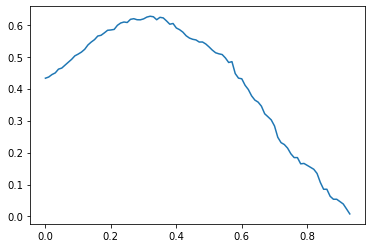

In [35]:
x_plot = [x[0] for x in dane_do_wykr_f1]
y_plot = [x[1] for x in dane_do_wykr_f1]
plt.plot(x_plot,y_plot)        


In [36]:
max(dane_do_wykr_f1,key=lambda item:item[1])

(0.32, 0.6264653696498054)

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [37]:
df_full_train = df_full_train[['seniority', 'income', 'assets', 'records', 'job', 'home','default']] 

In [39]:
from sklearn.model_selection import KFold

In [43]:
kfold = KFold(n_splits=5,shuffle=True, random_state=1)
train_idx, val_idx = next(kfold.split(df_full_train))


In [44]:
train_idx.size/val_idx.size

3.997194950911641

In [45]:
df_train = df_full_train.iloc[train_idx]
df_val = df_full_train.iloc[val_idx]

In [46]:
df_train

,seniority,income,assets,records,job,home,default
1034,5,127,2000,no,fixed,private,0
3955,14,140,0,yes,fixed,parents,0
398,25,250,100000,no,freelance,owner,0
3889,3,90,6000,no,fixed,owner,0
2421,2,80,2500,no,fixed,private,1
...,...,...,...,...,...,...,...
4225,20,90,3500,no,fixed,owner,0
144,9,442,6000,no,fixed,rent,0
905,15,0,6500,no,freelance,owner,0
3980,12,195,0,no,fixed,rent,0


In [ ]:
!pip install tqdm

In [82]:
def train(df_train,y_train):
    
    train_dict = df_train[['seniority', 'income', 'assets', 'records', 'job', 'home']].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dict)
    y_train = df_train.default.values
    #val_dict = df_val.to_dict(orient='records')
    #X_val = dv.transform(val_dict)


    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    return dv, model
    

In [56]:
len(X_train), len(y_train)

(2672, 2672)

In [70]:
dv, model = train(df_train,y_train)

In [84]:
def predict(df,dv,model):
    val_dict = df_val.to_dict(orient='records')
    X = dv.transform(val_dict)
    y_pred = model.predict_proba(X)[:,1]
    return y_pred

In [72]:
y_train.size

2851

In [73]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5,shuffle=True, random_state=1)
train_idx, val_idx = next(kfold.split(df_full_train))

In [74]:
df_train = df_full_train.iloc[train_idx]
df_val = df_full_train.iloc[val_idx]

In [85]:
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    y_train = df_train.default.values
    y_val = df_val.default.values
    dv, model = train(df_train, y_train)
    y_pred=predict(df_val, dv, model)
    auc = roc_auc_score(y_val,y_pred)
    scores.append(auc)

In [80]:
len(y_val), len(y_pred)

(713, 2850)

In [81]:
len(df_val)

713

In [86]:
scores

[0.8255915255915256,
 0.8254275668911268,
 0.7892885611797529,
 0.8250108084738436,
 0.8054980087218927]

In [87]:
np.std(scores)

0.014621876713782171

How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std

In [89]:
def train(df_train,y_train,c):
    
    train_dict = df_train[['seniority', 'income', 'assets', 'records', 'job', 'home']].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dict)
    y_train = df_train.default.values
    #val_dict = df_val.to_dict(orient='records')
    #X_val = dv.transform(val_dict)


    model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
    model.fit(X_train, y_train)
    return dv, model
    

In [102]:
c_score_mean = []
c_score_std = []

for c in [0.01, 0.1, 1, 10]:
    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        y_train = df_train.default.values
        y_val = df_val.default.values
        dv, model = train(df_train, y_train,c)
        y_pred=predict(df_val, dv, model)
        auc = roc_auc_score(y_val,y_pred)
        scores.append(auc)
    c_score_mean.append(round(np.mean(scores),3))
    c_score_std.append(round(np.std(scores),3))
    

In [103]:
c_score_mean

[0.809, 0.813, 0.814, 0.814]

In [104]:
c_score_std

[0.013, 0.014, 0.015, 0.015]

Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.